Epoch 1, Loss: 0.8520
Validation Accuracy: 78.75%
Epoch 2, Loss: 0.4908
Validation Accuracy: 82.71%
Epoch 3, Loss: 0.3191
Validation Accuracy: 79.33%
Epoch 4, Loss: 0.2331
Validation Accuracy: 81.02%
Epoch 5, Loss: 0.2182
Validation Accuracy: 80.82%


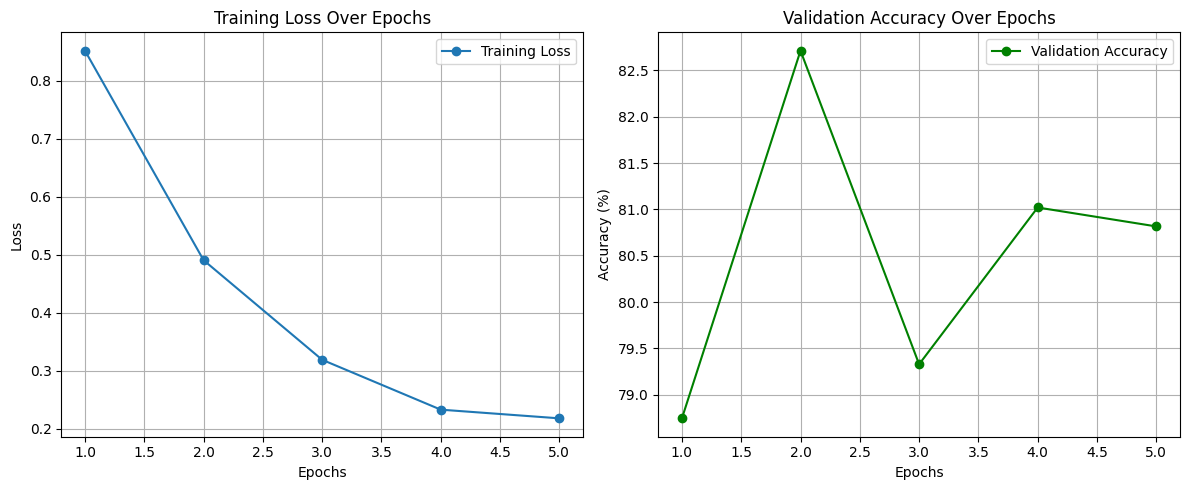

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("./food_data/train", transform=transform)
val_dataset = datasets.ImageFolder("./food_data/val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

train_losses = []
val_accuracies = []

def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
        val_accuracy = validate(model)
        val_accuracies.append(val_accuracy)

def validate(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return accuracy

def plot_metrics():
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    train_model(model, epochs=5)
    torch.save(model.state_dict(), 'food_classifier.pth')
    plot_metrics()
